# Comparing metrics

We now have a three broad metric categories and pipelines for calculating these. Each metric can be calculated using a range of heat measures (temperature, apparent temperature) and indicators (max, min, mean) as well as any internal variables. 

The package 'metrics' contains functions which implement each metric. We will run each metric for every combination of measure and indicator and compare the correlation to deaths. We will attempt to threshold the metrics finding the values where deaths occur.

### Things to achieve in this notebook

[✔] Run the building simulation with heating set-point set low

[✔] Calculate each metric for the simulation output

[✔] Compare correlation coefficients

### Import useful packages

In [28]:
import besos.eppy_funcs as ef
from besos.evaluator import EvaluatorEH, EvaluatorEP
from besos.problem import EPProblem, EHProblem, Problem
from besos.objectives import VariableReader, MeterReader
from besos import objectives
from besos.parameters import RangeParameter, CategoryParameter, Parameter, FieldSelector, GenericSelector
from besos import config
import pvlib
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime
import metpy.calc
import metrics.metrics

### Run the simulation for each heatwave

Output temperature and humidity for each heatwave. Set heating set point low.

In [29]:
# Get the building model and specify the .epw
directory = './Building_models/5A_complete_data_sorted/no error/'
filename = 'SF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'#'MF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'
building = ef.get_building(directory + filename)

# Create dataframe to store results
column_names = ['02061982T', '02061982RH', '04071983T', '04071983RH', '15081995T', '15081995RH', 
                '20071989T', '20071989RH', '21071994T', '21071994RH', '23061976T', '23061976RH', 
                '23081990T', '23081990RH', '25071995T', '25071995RH', '26071983T', '26071983RH',
                '27061986T', '27061986RH', '31071990T', '31071990RH']
data_store = pd.DataFrame(columns = column_names)

# Loop over heatwaves with death data 

filenames = ['02061982', '04071983', '15081995', '20071989', '21071994', 
             '23061976', '23081990', '25071995', '26071983', '27061986', '31071990']

for filename_epw in filenames:
    epw_path = './observed_heatwaves/' + filename_epw + '.epw'
    
    # Set the cooling setpoint high so that HVAC system is not triggered during heatwave
    EPparameters = []
    EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                               selector=FieldSelector(class_name='Schedule:Compact',
                                                      object_name='cooling_sch',field_name='Field 4'),
                               value_descriptors=RangeParameter(min_val=20.1,max_val=40)))
    
    EPparameters.append(Parameter(name='Heating Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='heating_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=0,max_val=20)))
    
    # Collect air temperature and humidity as outputs across all zones.
    EPobjectives = []
    outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
    for output in outputs:
        for u in [1,]:
            for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
                EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

    # Setting up the EnergyPlus simulation
    problem = EPProblem(EPparameters,EPobjectives)
    evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

    # Running a single simulation with cooling set point specified to be 40°C
    results = evaluator.eval_single([40, 0])
    
    # Storing results (living space only)
    T = results[0]
    RH = results[3]
    data_store[filename_epw + 'T'] = T
    data_store[filename_epw + 'RH'] = RH

/home/user/.local/lib/python3.7/site-packages/besos/problem.py:152: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Zone Mean Air Temperature', 3), ('Zone Air Relative Humidity', 3)]
Attempting to fix automatically
  f"Duplicate names found. (duplicate, repetitions): "
/home/user/.local/lib/python3.7/site-packages/besos/objectives.py:225: UserWarning: `time_series_values` is incomplete, and returns raw values, not time series values.
  "`time_series_values` is incomplete, and returns raw values, not time series values."


#### Plotting

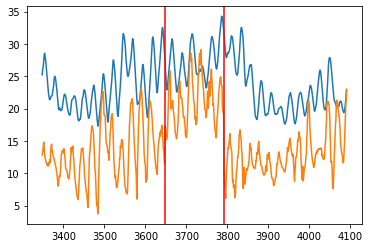

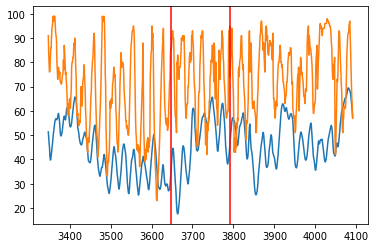

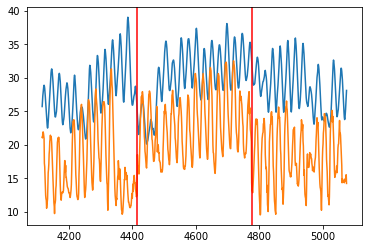

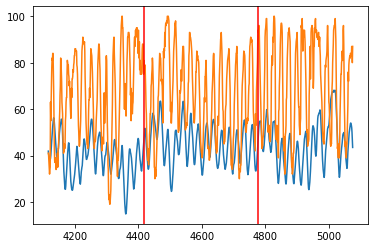

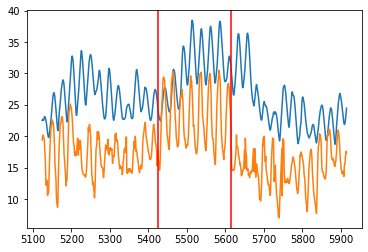

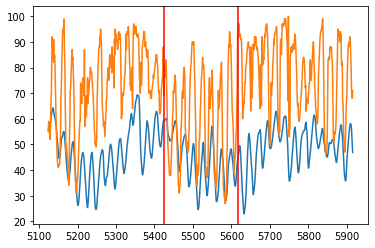

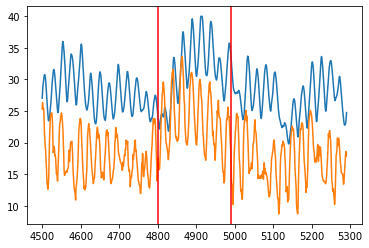

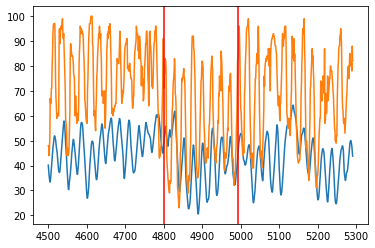

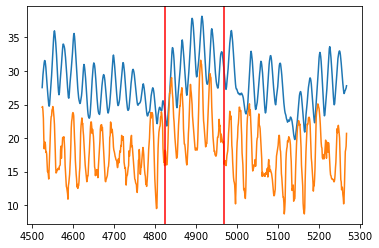

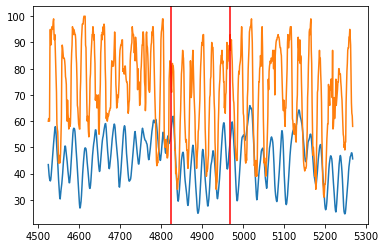

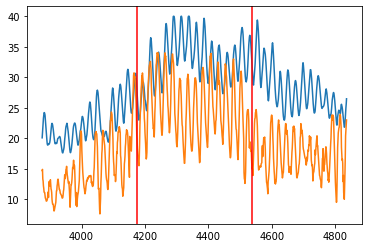

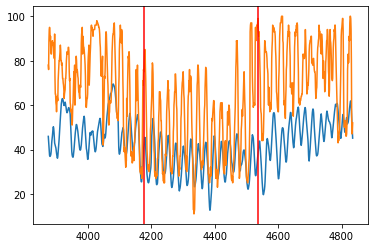

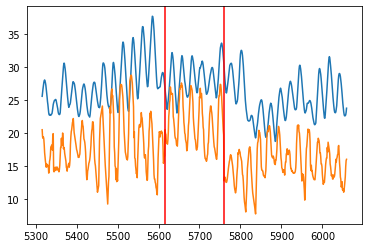

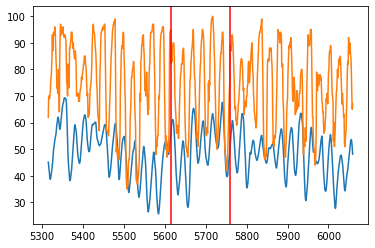

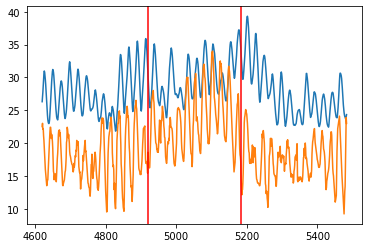

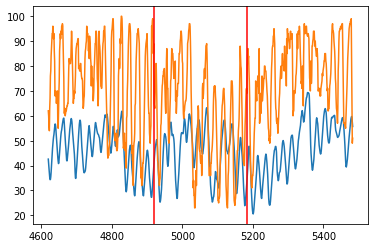

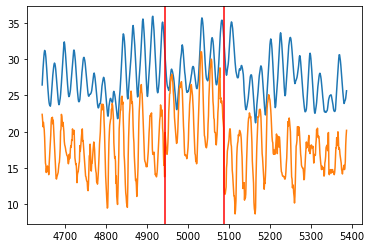

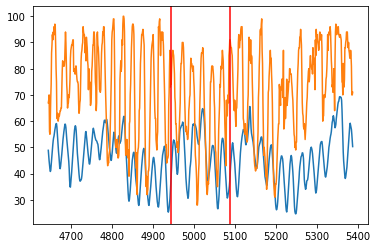

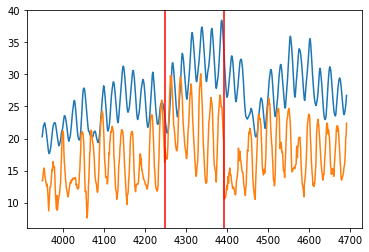

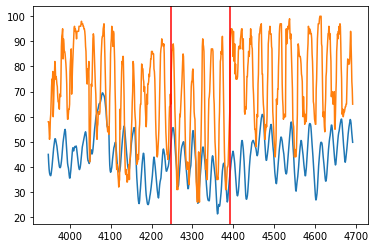

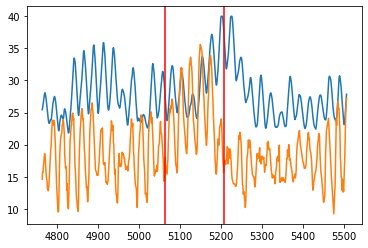

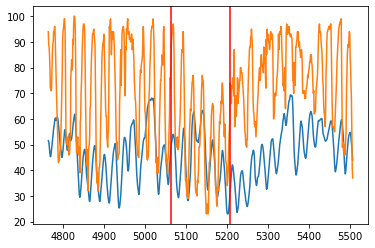

In [30]:
# Plot temperature and humidity for each heatwave marking on heatwave days
for filename_epw in filenames:
    epw_path = './observed_heatwaves/' + filename_epw + '.epw'
    # Extract start and end date
    excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
    for i in range(len(excess_deaths)):
        if excess_deaths.iloc[i][0] == int(filename_epw):
            dates = [excess_deaths.iloc[i][1], excess_deaths.iloc[i][2]]
            deaths = excess_deaths.iloc[i][4]
            
    # Find start and end hour
    start_date = datetime.strptime(dates[0], '%d/%m/%Y')
    start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
    start_hour = (start_day-1)*24

    end_date = datetime.strptime(dates[1], '%d/%m/%Y')
    end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
    end_hour = end_day*24
    
    limits = [start_hour-300, end_hour+300]
    
    df, metadata = pvlib.iotools.read_epw(epw_path)
    df = df.reset_index(drop=True)
    
    data_store[filename_epw + 'T'].iloc[limits[0]:limits[1]].plot()
    df['temp_air'].iloc[limits[0]:limits[1]].plot()
    plt.axvline(x=start_hour, c='r')
    plt.axvline(x=end_hour, c='r')
    plt.show()

    data_store[filename_epw + 'RH'].iloc[limits[0]:limits[1]].plot()
    df['relative_humidity'].iloc[limits[0]:limits[1]].plot()
    plt.axvline(x=start_hour, c='r')
    plt.axvline(x=end_hour, c='r')
    #plt.ylim([0,30])
    plt.show()



### Calculate all metrics

In [31]:
## Set up 
column_names = ['heatwave', 'value', 'deaths']
excess_deaths = pd.read_csv('./observed_heatwaves/excess_deaths.csv')
excess_deaths = excess_deaths.set_index('name')
heatwaves = excess_deaths.index.tolist()

In [32]:
## Duration boosted intensity
measures = ['Temperature', 'Apparent']
indicators = ['peak', 'min', 'avg']
metrics_df = pd.DataFrame(columns = ['metric', 'corr_p', 'corr_s'])

for measure in measures:
    for indicator in indicators:
        metric_df = pd.DataFrame(columns = column_names)
        i = 0
        for heatwave in heatwaves:
            heatwave_str = str(heatwave)
            if len(heatwave_str) == 7:
                heatwave_str = '0' + heatwave_str
            T = data_store[heatwave_str + 'T']
            RH = data_store[heatwave_str + 'RH']
            dates = [excess_deaths['start_date'][heatwave], excess_deaths['end_date'][heatwave]]
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24
            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24
            T = T[start_hour: end_hour]
            RH = RH[start_hour: end_hour]
            
            value = metrics.metrics.duration_boosted_intensity(T, RH, measure, indicator)
            deaths = excess_deaths['excess_deaths'][heatwave]
            metric_df.loc[i] = [heatwave_str, value, deaths]
            i = i + 1
        corr_mat = metric_df.corr('pearson')
        corr_p = corr_mat.loc['deaths', 'value']
        corr_mat = metric_df.corr('spearman')
        corr_s = corr_mat.loc['deaths', 'value']
        
        metrics_df = metrics_df.append({'metric':'DBI_' + measure + '_' + indicator,
                                        'corr_p':corr_p,
                                        'corr_s':corr_s}, ignore_index = True)

In [33]:
## Cumulative metric
measures = ['Temperature', 'Apparent']
timesteps = ['hourly', 'daily', 'bidaily']

for measure in measures:
    for ts in timesteps:
        metric_df = pd.DataFrame(columns = column_names)
        i = 0
        for heatwave in heatwaves:
            heatwave_str = str(heatwave)
            if len(heatwave_str) == 7:
                heatwave_str = '0' + heatwave_str
            T = data_store[heatwave_str + 'T']
            RH = data_store[heatwave_str + 'RH']
            dates = [excess_deaths['start_date'][heatwave], excess_deaths['end_date'][heatwave]]
            # Find start and end hour
            start_date = datetime.strptime(dates[0], '%d/%m/%Y')
            start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
            start_hour = (start_day-1)*24
            end_date = datetime.strptime(dates[1], '%d/%m/%Y')
            end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
            end_hour = end_day*24
            T = T[start_hour: end_hour]
            RH = RH[start_hour: end_hour]
            
            value = metrics.metrics.cumulative_metric(T, RH, ts, measure)
            deaths = excess_deaths['excess_deaths'][heatwave]
            metric_df.loc[i] = [heatwave_str, value, deaths]
            i = i + 1
        corr_mat = metric_df.corr('pearson')
        corr_p = corr_mat.loc['deaths', 'value']
        corr_mat = metric_df.corr('spearman')
        corr_s = corr_mat.loc['deaths', 'value']
        
        metrics_df = metrics_df.append({'metric':'Cumulative_' + measure + '_' + ts,
                                        'corr_p':corr_p,
                                        'corr_s':corr_s}, ignore_index = True)

In [34]:
## HWMI metric
## Cumulative metric
measures = ['Temperature', 'Apparent']
indicators = ['peak', 'min', 'avg']
chunck_sizes = [2, 3, 4]

for measure in measures:
    for ts in timesteps:
        for chunk_size in chunck_sizes:
            metric_df = pd.DataFrame(columns = column_names)
            i = 0
            for heatwave in heatwaves:
                heatwave_str = str(heatwave)
                if len(heatwave_str) == 7:
                    heatwave_str = '0' + heatwave_str
                T = data_store[heatwave_str + 'T']
                RH = data_store[heatwave_str + 'RH']
                dates = [excess_deaths['start_date'][heatwave], excess_deaths['end_date'][heatwave]]
                # Find start and end hour
                start_date = datetime.strptime(dates[0], '%d/%m/%Y')
                start_day = (start_date - datetime(start_date.year, 1, 1)).days + 1
                start_hour = (start_day-1)*24
                end_date = datetime.strptime(dates[1], '%d/%m/%Y')
                end_day = (end_date - datetime(end_date.year, 1, 1)).days + 1
                end_hour = end_day*24
                T = T[start_hour: end_hour]
                RH = RH[start_hour: end_hour]

                value = metrics.metrics.HWMI_metric(T, RH, chunk_size, measure, indicator)
                deaths = excess_deaths['excess_deaths'][heatwave]
                metric_df.loc[i] = [heatwave_str, value, deaths]
                i = i + 1
            corr_mat = metric_df.corr('pearson')
            corr_p = corr_mat.loc['deaths', 'value']
            corr_mat = metric_df.corr('spearman')
            corr_s = corr_mat.loc['deaths', 'value']

            metrics_df = metrics_df.append({'metric':'HWMI_' + measure + '_' + indicator + '_' + str(chunk_size),
                                            'corr_p':corr_p,
                                            'corr_s':corr_s}, ignore_index = True)





In [35]:
metrics_df #add p values? add lag?

metric    corr_p    corr_s
0             DBI_Temperature_peak  0.671741  0.581818
1              DBI_Temperature_min  0.676090  0.618182
2              DBI_Temperature_avg  0.670976  0.463636
3                DBI_Apparent_peak  0.657816  0.563636
4                 DBI_Apparent_min  0.650263  0.654545
5                 DBI_Apparent_avg  0.654900  0.463636
6    Cumulative_Temperature_hourly  0.774883  0.390909
7     Cumulative_Temperature_daily  0.798480  0.510379
8   Cumulative_Temperature_bidaily  0.720660  0.479457
9       Cumulative_Apparent_hourly  0.729148  0.418182
10       Cumulative_Apparent_daily  0.666607  0.458735
11     Cumulative_Apparent_bidaily  0.663831  0.449560
12          HWMI_Temperature_avg_2  0.670101  0.509091
13          HWMI_Temperature_avg_3  0.618388  0.372727
14          HWMI_Temperature_avg_4  0.701498  0.672727
15          HWMI_Temperature_avg_2  0.670101  0.509091
16          HWMI_Temperature_avg_3  0.618388  0.372727
17          HWMI_Temperature_avg_4  0.701498  0.672727
18          HWMI_Temperature_avg_2  0.670101  0.509091
19          HWMI_Temperature_avg_3  0.618388  0.372727
20          HWMI_Temperature_avg_4  0.701498  0.672727
21             HWMI_Apparent_avg_2  0.654033  0.509091
22             HWMI_Apparent_avg_3  0.604695  0.354545
23             HWMI_Apparent_avg_4  0.688956  0.590909
24             HWMI_Apparent_avg_2  0.654033  0.509091
25             HWMI_Apparent_avg_3  0.604695  0.354545
26             HWMI_Apparent_avg_4  0.688956  0.590909
27             HWMI_Apparent_avg_2  0.654033  0.509091
28             HWMI_Apparent_avg_3  0.604695  0.354545
29             HWMI_Apparent_avg_4  0.688956  0.590909

In [36]:
metrics_df.to_csv('./metrics.csv')

**How will I use these metrics?** The cumulative metric will help to define heat events in buildings and their severity. I will also use the other metrics to gauge severity.

### Other metrics

In [38]:
data_store

02061982T  02061982RH     04071983T  04071983RH     15081995T  \
0    -7.677320e-17   24.715099 -7.677320e-17   24.715099 -7.677320e-17   
1     9.079141e-17   23.556921  9.079141e-17   23.556921  9.079141e-17   
2    -1.983336e-16   22.713806 -1.983336e-16   22.713806 -1.983336e-16   
3    -1.200341e-16   22.137372 -1.200341e-16   22.137372 -1.200341e-16   
4    -6.134572e-17   21.761034 -6.134572e-17   21.761034 -6.134572e-17   
...            ...         ...           ...         ...           ...   
8803  1.272836e+01   59.759323  1.272856e+01   59.758604  1.272836e+01   
8804  1.303962e+01   59.168970  1.303983e+01   59.168220  1.303964e+01   
8805  1.317183e+01   58.742273  1.317234e+01   58.740348  1.317184e+01   
8806  1.298703e+01   58.678358  1.298717e+01   58.677877  1.298704e+01   
8807  1.250022e+01   58.462143  1.250024e+01   58.462139  1.250021e+01   

      15081995RH     20071989T  20071989RH     21071994T  21071994RH  ...  \
0      24.715099 -7.677320e-17   24.715099 -7.677320e-17   24.715099  ...   
1      23.556921  9.079141e-17   23.556921  9.079141e-17   23.556921  ...   
2      22.713806 -1.983336e-16   22.713806 -1.983336e-16   22.713806  ...   
3      22.137372 -1.200341e-16   22.137372 -1.200341e-16   22.137372  ...   
4      21.761034 -6.134572e-17   21.761034 -6.134572e-17   21.761034  ...   
...          ...           ...         ...           ...         ...  ...   
8803   59.759322  1.272848e+01   59.758926  1.272852e+01   59.758736  ...   
8804   59.168875  1.303994e+01   59.167790  1.303987e+01   59.168052  ...   
8805   58.742219  1.317226e+01   58.740675  1.317231e+01   58.740474  ...   
8806   58.678306  1.298726e+01   58.677527  1.298720e+01   58.677741  ...   
8807   58.462189  1.250013e+01   58.462590  1.250020e+01   58.462313  ...   

         23081990T  23081990RH     25071995T  25071995RH     26071983T  \
0    -7.677320e-17   24.715099 -7.677320e-17   24.715099 -7.677320e-17   
1     9.079141e-17   23.556921  9.079141e-17   23.556921  9.079141e-17   
2    -1.983336e-16   22.713806 -1.983336e-16   22.713806 -1.983336e-16   
3    -1.200341e-16   22.137372 -1.200341e-16   22.137372 -1.200341e-16   
4    -6.134572e-17   21.761034 -6.134572e-17   21.761034 -6.134572e-17   
...            ...         ...           ...         ...           ...   
8803  1.272841e+01   59.759098  1.272837e+01   59.759343  1.272836e+01   
8804  1.303942e+01   59.169723  1.304010e+01   59.167157  1.303962e+01   
8805  1.317177e+01   58.742456  1.317212e+01   58.741220  1.317183e+01   
8806  1.298710e+01   58.678056  1.298740e+01   58.677005  1.298703e+01   
8807  1.250019e+01   58.462262  1.249993e+01   58.463360  1.250022e+01   

      26071983RH     27061986T  27061986RH     31071990T  31071990RH  
0      24.715099 -7.677320e-17   24.715099 -7.677320e-17   24.715099  
1      23.556921  9.079141e-17   23.556921  9.079141e-17   23.556921  
2      22.713806 -1.983336e-16   22.713806 -1.983336e-16   22.713806  
3      22.137372 -1.200341e-16   22.137372 -1.200341e-16   22.137372  
4      21.761034 -6.134572e-17   21.761034 -6.134572e-17   21.761034  
...          ...           ...         ...           ...         ...  
8803   59.759323  1.272833e+01   59.759506  1.272847e+01   59.758947  
8804   59.168975  1.304022e+01   59.166700  1.303995e+01   59.167760  
8805   58.742277  1.317198e+01   58.741752  1.317225e+01   58.740699  
8806   58.678360  1.298763e+01   58.676091  1.298727e+01   58.677501  
8807   58.462140  1.250083e+01   58.459875  1.250012e+01   58.462623  

[8808 rows x 22 columns]

In [102]:
columns = ['heatwave', 'metric', 'deaths']
temp_columns = list(data_store.columns[0::2])
threshold_metric = pd.DataFrame(columns = columns)
i = 0
for column in temp_columns:
    name = column[:-1]
    data = data_store[column]
    array = np.where(data >= 28, 1,0)  
    value = float(sum(array))
    deaths = excess_deaths['excess_deaths'][int(name)]                                    
    threshold_metric = threshold_metric.append({'heatwave': name, 'metric': value, 'deaths': deaths}, ignore_index = True)
    i = i + 1

In [103]:
threshold_metric

heatwave  metric  deaths
0   02061982   840.0    0.03
1   04071983   947.0   11.28
2   15081995   837.0   -3.03
3   20071989   827.0   10.96
4   21071994   810.0   -0.19
5   23061976   965.0   30.69
6   23081990   847.0    5.39
7   25071995   876.0    7.13
8   26071983   817.0    4.46
9   27061986   810.0    3.54
10  31071990   829.0   16.82

In [104]:
corr_mat = threshold_metric.corr('spearman')          
corr_mat.iloc[0,1]

0.5375868161422821

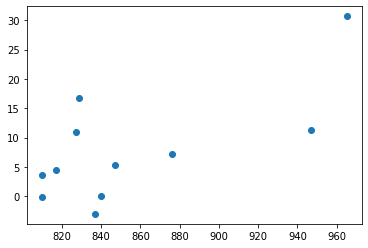

In [105]:
plt.scatter(threshold_metric['metric'], threshold_metric['deaths'])